# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

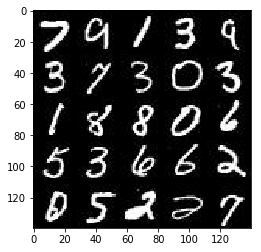

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

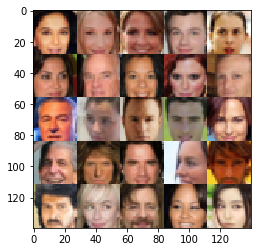

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def lrelu(x, alpha):
    return tf.maximum(x, alpha * x)

In [7]:
def discriminator(images, reuse=False, alpha=0.2, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x1 = lrelu(x1, alpha)
#         print("x1: ", x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = lrelu(tf.layers.batch_normalization(x2, training=True), alpha)
#         print("x2: ", x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = lrelu(tf.layers.batch_normalization(x3, training=True), alpha)
#         print("x3: ", x3)
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = lrelu(tf.layers.batch_normalization(x4, training=True), alpha)
#         print("x4: ", x4)
    
        flat = tf.reshape(x4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = lrelu(tf.layers.batch_normalization(x1, training=is_train), alpha)
#         print("x1: ", x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 3, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = lrelu(tf.layers.batch_normalization(x2, training=is_train), alpha)
#         print("x2: ", x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = lrelu(tf.layers.batch_normalization(x3, training=is_train), alpha)
#         print("x3: ", x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 3, strides=2, padding='same', 
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = lrelu(tf.layers.batch_normalization(x4, training=is_train), alpha)
#         print("x4: ", x4)
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # 28x28xout_channel_dim
        #print("logits: ", logits)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    d_fake_labels = tf.zeros_like(d_model_fake)
    g_labels = tf.ones_like(d_model_fake)
    
    d_cross_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_real_labels)
    d_cross_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_fake_labels)
    g_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels)
    
    d_loss = tf.reduce_mean(d_cross_real) + tf.reduce_mean(d_cross_fake)
    g_loss = tf.reduce_mean(g_cross)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [update for update in update_ops if update.name.startswith('generator')]
    with tf.control_dependencies(g_update_ops):       
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
        d_min_opt = d_train_opt.minimize(d_loss, var_list=d_vars)
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
        g_min_opt = g_train_opt.minimize(g_loss, var_list=g_vars)
    
        return d_min_opt, g_min_opt, g_vars


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
!mkdir 'checkpoints'

mkdir: cannot create directory ‘checkpoints’: File exists


In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          show_every_n=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    img_width, img_height, img_depth = data_shape[1:]
    
    input_r, input_z, learning_rate_ = model_inputs(img_width, img_height, img_depth, z_dim)
    
    d_loss, g_loss = model_loss(input_r, input_z, img_depth, smooth=0)
    
    d_min_opt, g_min_opt, g_vars = model_opt(d_loss, g_loss, learning_rate_, beta1)
    
    losses = list()
    samples = list()
    steps = 0

    saver = tf.train.Saver(var_list=g_vars)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # scale images
                batch_images = batch_images * 2.0
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                sess.run(d_min_opt, feed_dict={input_r: batch_images,
                                               input_z: batch_z,
                                               learning_rate_: learning_rate})
                sess.run(g_min_opt, feed_dict={input_z: batch_z,
                                               learning_rate_: learning_rate})
             
                if steps % (show_every_n * 10) == 0:
                    show_generator_output(sess, 10, input_z, img_depth, data_image_mode)
            
                if steps % show_every_n == 0:
                    # At the end of each epoch, get the losses and print them out
                    d_train_loss = d_loss.eval({input_z: batch_z, input_r: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})

                    print("Epoch {:4}/{}\tD Loss: {:>.4f}\tG Loss: {:>.4f}".format(epoch_i + 1, 
                                                                                     epochs, 
                                                                                     d_train_loss,
                                                                                     g_train_loss))
                    # Save losses to view after training
                    losses.append((d_train_loss, g_train_loss))

                    # Sample from generator as we're training for viewing afterwards
                    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
                    gen_samples = sess.run(generator(input_z, img_depth, is_train=False), feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch    1/2	D Loss: 0.2302	G Loss: 2.2268
Epoch    1/2	D Loss: 0.9713	G Loss: 0.5811
Epoch    1/2	D Loss: 1.3142	G Loss: 0.5416
Epoch    1/2	D Loss: 2.6582	G Loss: 0.0981
Epoch    1/2	D Loss: 1.2243	G Loss: 7.2504
Epoch    1/2	D Loss: 0.2306	G Loss: 2.1431
Epoch    1/2	D Loss: 0.3955	G Loss: 6.9628
Epoch    1/2	D Loss: 0.5961	G Loss: 4.7717
Epoch    1/2	D Loss: 0.6451	G Loss: 0.8662


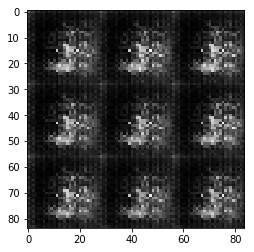

Epoch    1/2	D Loss: 0.1625	G Loss: 9.3807
Epoch    1/2	D Loss: 0.1666	G Loss: 5.4046
Epoch    1/2	D Loss: 0.6826	G Loss: 8.0799
Epoch    1/2	D Loss: 0.2210	G Loss: 5.9125
Epoch    1/2	D Loss: 0.2073	G Loss: 2.7049
Epoch    1/2	D Loss: 0.1723	G Loss: 2.5825
Epoch    1/2	D Loss: 0.2798	G Loss: 1.8423
Epoch    1/2	D Loss: 0.2261	G Loss: 2.2052
Epoch    1/2	D Loss: 0.1710	G Loss: 2.7097
Epoch    1/2	D Loss: 0.5459	G Loss: 1.2270


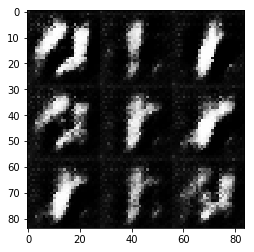

Epoch    1/2	D Loss: 1.2541	G Loss: 1.6618
Epoch    1/2	D Loss: 0.5591	G Loss: 3.1859
Epoch    1/2	D Loss: 0.3563	G Loss: 3.0238
Epoch    1/2	D Loss: 0.2704	G Loss: 1.9468
Epoch    1/2	D Loss: 0.3189	G Loss: 2.6296
Epoch    1/2	D Loss: 0.2858	G Loss: 5.1344
Epoch    1/2	D Loss: 0.2355	G Loss: 2.7430
Epoch    1/2	D Loss: 0.2454	G Loss: 2.9780
Epoch    1/2	D Loss: 1.2742	G Loss: 6.0904
Epoch    1/2	D Loss: 0.6615	G Loss: 1.4346


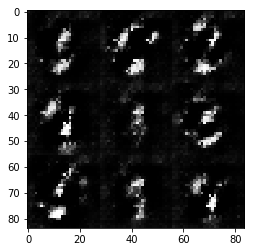

Epoch    1/2	D Loss: 0.7701	G Loss: 1.4194
Epoch    1/2	D Loss: 0.3124	G Loss: 2.3795
Epoch    1/2	D Loss: 0.3107	G Loss: 3.2041
Epoch    1/2	D Loss: 0.5964	G Loss: 1.4711
Epoch    1/2	D Loss: 0.3388	G Loss: 2.7458
Epoch    1/2	D Loss: 0.5653	G Loss: 1.8553
Epoch    1/2	D Loss: 0.4892	G Loss: 2.7779
Epoch    1/2	D Loss: 0.6713	G Loss: 2.1705
Epoch    1/2	D Loss: 0.3680	G Loss: 2.1690
Epoch    1/2	D Loss: 0.5948	G Loss: 1.2588


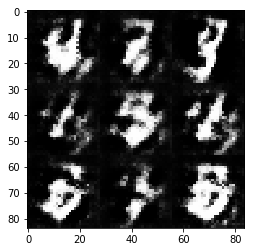

Epoch    1/2	D Loss: 0.5460	G Loss: 1.4330
Epoch    1/2	D Loss: 0.3943	G Loss: 2.4033
Epoch    1/2	D Loss: 1.1623	G Loss: 5.9533
Epoch    1/2	D Loss: 0.4047	G Loss: 1.9114
Epoch    1/2	D Loss: 0.4066	G Loss: 2.3801
Epoch    1/2	D Loss: 0.7628	G Loss: 3.2711
Epoch    1/2	D Loss: 0.6984	G Loss: 1.2796
Epoch    2/2	D Loss: 0.4372	G Loss: 1.8574
Epoch    2/2	D Loss: 0.5937	G Loss: 1.4388
Epoch    2/2	D Loss: 1.0486	G Loss: 4.4675


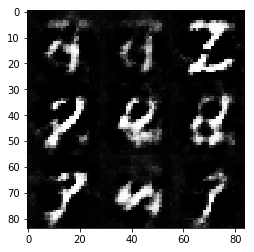

Epoch    2/2	D Loss: 0.7629	G Loss: 1.1918
Epoch    2/2	D Loss: 1.2368	G Loss: 0.4859
Epoch    2/2	D Loss: 0.8165	G Loss: 1.0626
Epoch    2/2	D Loss: 0.8816	G Loss: 2.9136
Epoch    2/2	D Loss: 0.6610	G Loss: 1.1092
Epoch    2/2	D Loss: 0.5495	G Loss: 2.4837
Epoch    2/2	D Loss: 0.6821	G Loss: 1.8703
Epoch    2/2	D Loss: 0.5493	G Loss: 1.7305
Epoch    2/2	D Loss: 0.7108	G Loss: 1.1254
Epoch    2/2	D Loss: 0.5946	G Loss: 1.2673


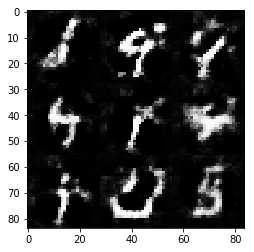

Epoch    2/2	D Loss: 0.4515	G Loss: 2.2759
Epoch    2/2	D Loss: 0.5516	G Loss: 1.8277
Epoch    2/2	D Loss: 0.4782	G Loss: 2.7936
Epoch    2/2	D Loss: 0.7251	G Loss: 2.1968
Epoch    2/2	D Loss: 0.5795	G Loss: 1.9401
Epoch    2/2	D Loss: 0.6837	G Loss: 1.0009
Epoch    2/2	D Loss: 0.8249	G Loss: 0.8625
Epoch    2/2	D Loss: 0.5796	G Loss: 1.5332
Epoch    2/2	D Loss: 0.5273	G Loss: 2.1088
Epoch    2/2	D Loss: 0.6188	G Loss: 1.1579


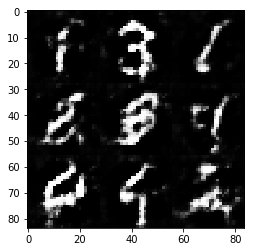

Epoch    2/2	D Loss: 0.9605	G Loss: 0.7634
Epoch    2/2	D Loss: 0.5788	G Loss: 1.3918
Epoch    2/2	D Loss: 0.5515	G Loss: 1.6345
Epoch    2/2	D Loss: 0.9447	G Loss: 4.1280
Epoch    2/2	D Loss: 0.4580	G Loss: 2.1557
Epoch    2/2	D Loss: 0.7105	G Loss: 1.1199
Epoch    2/2	D Loss: 0.5565	G Loss: 1.8387
Epoch    2/2	D Loss: 0.7170	G Loss: 1.3997
Epoch    2/2	D Loss: 0.9508	G Loss: 0.7531
Epoch    2/2	D Loss: 0.6449	G Loss: 2.4964


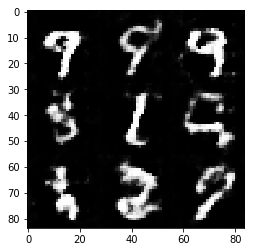

Epoch    2/2	D Loss: 0.6791	G Loss: 1.2770
Epoch    2/2	D Loss: 0.5986	G Loss: 1.9404
Epoch    2/2	D Loss: 0.7096	G Loss: 2.7504
Epoch    2/2	D Loss: 0.9170	G Loss: 3.4735
Epoch    2/2	D Loss: 0.5213	G Loss: 2.0822
Epoch    2/2	D Loss: 0.4664	G Loss: 1.7439
Epoch    2/2	D Loss: 0.5997	G Loss: 1.3034
Epoch    2/2	D Loss: 1.0124	G Loss: 0.6813
Epoch    2/2	D Loss: 0.9370	G Loss: 2.9591
Epoch    2/2	D Loss: 0.5681	G Loss: 1.5648


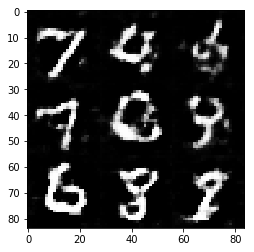

Epoch    2/2	D Loss: 0.6649	G Loss: 0.9947
Epoch    2/2	D Loss: 0.5560	G Loss: 1.5702
Epoch    2/2	D Loss: 0.6065	G Loss: 1.6104
Epoch    2/2	D Loss: 0.8360	G Loss: 0.9201


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 10)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch    1/1	D Loss: 0.3876	G Loss: 9.0460
Epoch    1/1	D Loss: 0.0552	G Loss: 6.8900
Epoch    1/1	D Loss: 0.0787	G Loss: 7.3382
Epoch    1/1	D Loss: 2.5728	G Loss: 11.3652
Epoch    1/1	D Loss: 0.1368	G Loss: 4.7042
Epoch    1/1	D Loss: 0.0701	G Loss: 5.3660
Epoch    1/1	D Loss: 0.7975	G Loss: 0.9366
Epoch    1/1	D Loss: 0.6174	G Loss: 1.6872
Epoch    1/1	D Loss: 1.7116	G Loss: 0.3742


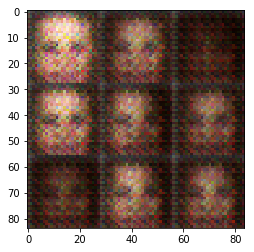

Epoch    1/1	D Loss: 0.4701	G Loss: 1.7253
Epoch    1/1	D Loss: 0.7596	G Loss: 0.9332
Epoch    1/1	D Loss: 0.3050	G Loss: 3.1448
Epoch    1/1	D Loss: 1.0981	G Loss: 0.6077
Epoch    1/1	D Loss: 0.8531	G Loss: 0.9892
Epoch    1/1	D Loss: 0.7450	G Loss: 3.9863
Epoch    1/1	D Loss: 0.2474	G Loss: 2.2843
Epoch    1/1	D Loss: 1.4906	G Loss: 5.2296
Epoch    1/1	D Loss: 1.1262	G Loss: 4.5945
Epoch    1/1	D Loss: 0.9624	G Loss: 3.7267


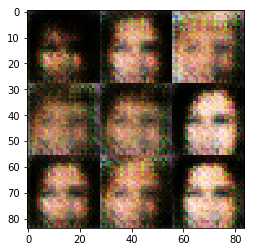

Epoch    1/1	D Loss: 0.9783	G Loss: 4.2679
Epoch    1/1	D Loss: 1.1561	G Loss: 0.5581
Epoch    1/1	D Loss: 0.5428	G Loss: 1.6781
Epoch    1/1	D Loss: 0.8342	G Loss: 1.1213
Epoch    1/1	D Loss: 1.1352	G Loss: 3.2862
Epoch    1/1	D Loss: 0.5787	G Loss: 1.4839
Epoch    1/1	D Loss: 0.7921	G Loss: 0.9173
Epoch    1/1	D Loss: 1.1910	G Loss: 0.4756
Epoch    1/1	D Loss: 0.4682	G Loss: 1.3873
Epoch    1/1	D Loss: 0.8780	G Loss: 3.1419


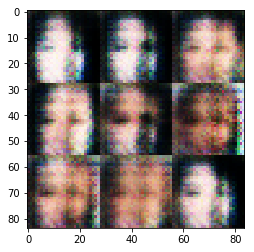

Epoch    1/1	D Loss: 0.7647	G Loss: 0.9266
Epoch    1/1	D Loss: 0.6432	G Loss: 1.3028
Epoch    1/1	D Loss: 0.9523	G Loss: 0.8054
Epoch    1/1	D Loss: 0.5575	G Loss: 1.7528
Epoch    1/1	D Loss: 0.7019	G Loss: 1.6677
Epoch    1/1	D Loss: 1.2217	G Loss: 0.4983
Epoch    1/1	D Loss: 0.6203	G Loss: 1.1160
Epoch    1/1	D Loss: 0.9080	G Loss: 0.9518
Epoch    1/1	D Loss: 1.0119	G Loss: 0.8647
Epoch    1/1	D Loss: 0.9971	G Loss: 1.0183


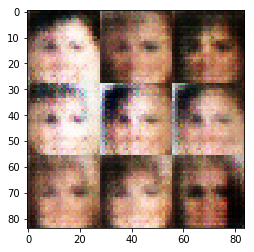

Epoch    1/1	D Loss: 1.3223	G Loss: 3.2904
Epoch    1/1	D Loss: 0.8268	G Loss: 0.9331
Epoch    1/1	D Loss: 0.7507	G Loss: 0.9575
Epoch    1/1	D Loss: 0.5592	G Loss: 1.2026
Epoch    1/1	D Loss: 0.4405	G Loss: 1.7579
Epoch    1/1	D Loss: 0.8717	G Loss: 0.9615
Epoch    1/1	D Loss: 0.5833	G Loss: 1.0503
Epoch    1/1	D Loss: 0.6264	G Loss: 1.1026
Epoch    1/1	D Loss: 0.6130	G Loss: 1.2001
Epoch    1/1	D Loss: 0.7114	G Loss: 1.7316


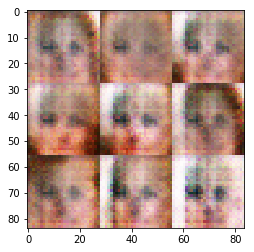

Epoch    1/1	D Loss: 1.1160	G Loss: 0.5836
Epoch    1/1	D Loss: 0.6405	G Loss: 1.3606
Epoch    1/1	D Loss: 0.7439	G Loss: 1.2694
Epoch    1/1	D Loss: 0.6054	G Loss: 1.7523
Epoch    1/1	D Loss: 0.8197	G Loss: 0.8169
Epoch    1/1	D Loss: 0.5628	G Loss: 1.7986
Epoch    1/1	D Loss: 0.5601	G Loss: 2.0511
Epoch    1/1	D Loss: 0.5487	G Loss: 2.1377
Epoch    1/1	D Loss: 0.7235	G Loss: 1.0907
Epoch    1/1	D Loss: 0.7636	G Loss: 1.0453


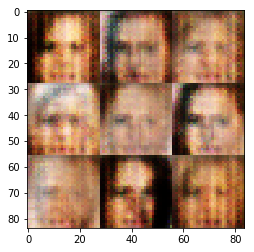

Epoch    1/1	D Loss: 0.6698	G Loss: 1.3654
Epoch    1/1	D Loss: 1.0337	G Loss: 0.6727
Epoch    1/1	D Loss: 0.9569	G Loss: 0.6974
Epoch    1/1	D Loss: 0.6909	G Loss: 1.2910
Epoch    1/1	D Loss: 0.7068	G Loss: 2.1649
Epoch    1/1	D Loss: 0.4680	G Loss: 2.5222
Epoch    1/1	D Loss: 0.6403	G Loss: 1.2661
Epoch    1/1	D Loss: 1.4751	G Loss: 0.3548
Epoch    1/1	D Loss: 0.7942	G Loss: 1.5803
Epoch    1/1	D Loss: 1.3050	G Loss: 0.6432


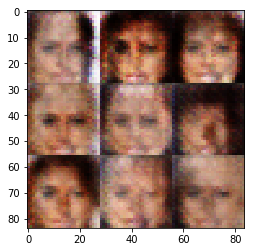

Epoch    1/1	D Loss: 1.6702	G Loss: 3.8855
Epoch    1/1	D Loss: 0.8500	G Loss: 1.0957
Epoch    1/1	D Loss: 0.9403	G Loss: 0.7679
Epoch    1/1	D Loss: 0.5167	G Loss: 1.3512
Epoch    1/1	D Loss: 0.8549	G Loss: 1.1337
Epoch    1/1	D Loss: 0.5942	G Loss: 1.2690
Epoch    1/1	D Loss: 0.4585	G Loss: 3.0308
Epoch    1/1	D Loss: 1.4504	G Loss: 0.3897
Epoch    1/1	D Loss: 1.0574	G Loss: 4.1758
Epoch    1/1	D Loss: 0.4771	G Loss: 1.7507


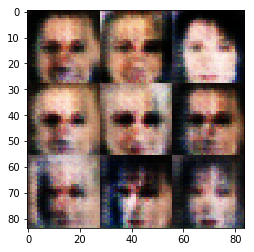

Epoch    1/1	D Loss: 0.6604	G Loss: 1.2873
Epoch    1/1	D Loss: 0.5101	G Loss: 2.0026
Epoch    1/1	D Loss: 0.7332	G Loss: 1.0959
Epoch    1/1	D Loss: 0.6922	G Loss: 0.9911
Epoch    1/1	D Loss: 1.1316	G Loss: 0.6616
Epoch    1/1	D Loss: 0.9569	G Loss: 0.8197
Epoch    1/1	D Loss: 0.5564	G Loss: 3.5279
Epoch    1/1	D Loss: 0.9070	G Loss: 0.9092
Epoch    1/1	D Loss: 0.7959	G Loss: 0.9129
Epoch    1/1	D Loss: 0.6335	G Loss: 1.7249


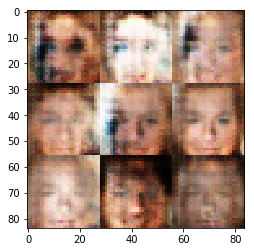

Epoch    1/1	D Loss: 0.7055	G Loss: 1.0941
Epoch    1/1	D Loss: 0.5001	G Loss: 2.3456
Epoch    1/1	D Loss: 0.6292	G Loss: 2.1848
Epoch    1/1	D Loss: 1.4548	G Loss: 0.3764
Epoch    1/1	D Loss: 0.7114	G Loss: 1.1295
Epoch    1/1	D Loss: 0.7191	G Loss: 1.2086
Epoch    1/1	D Loss: 1.1241	G Loss: 0.5548
Epoch    1/1	D Loss: 0.7729	G Loss: 2.0361
Epoch    1/1	D Loss: 0.8724	G Loss: 1.1186
Epoch    1/1	D Loss: 0.7451	G Loss: 1.1958


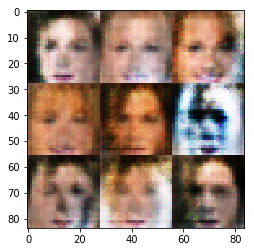

Epoch    1/1	D Loss: 0.9193	G Loss: 0.7086
Epoch    1/1	D Loss: 0.4960	G Loss: 2.1079
Epoch    1/1	D Loss: 0.6270	G Loss: 1.3080
Epoch    1/1	D Loss: 0.5375	G Loss: 1.5104
Epoch    1/1	D Loss: 0.6564	G Loss: 2.5830
Epoch    1/1	D Loss: 1.0499	G Loss: 3.4930
Epoch    1/1	D Loss: 1.0383	G Loss: 0.6752
Epoch    1/1	D Loss: 0.7057	G Loss: 1.0352
Epoch    1/1	D Loss: 0.7745	G Loss: 1.7984
Epoch    1/1	D Loss: 0.5790	G Loss: 1.3668


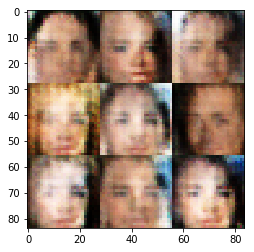

Epoch    1/1	D Loss: 0.5960	G Loss: 1.6224
Epoch    1/1	D Loss: 0.4873	G Loss: 2.0745
Epoch    1/1	D Loss: 0.5398	G Loss: 1.4671
Epoch    1/1	D Loss: 0.5291	G Loss: 2.3266
Epoch    1/1	D Loss: 0.4871	G Loss: 1.5389
Epoch    1/1	D Loss: 0.6348	G Loss: 2.5283
Epoch    1/1	D Loss: 0.6697	G Loss: 2.0914
Epoch    1/1	D Loss: 0.8123	G Loss: 2.7544
Epoch    1/1	D Loss: 0.5870	G Loss: 1.4373
Epoch    1/1	D Loss: 0.6341	G Loss: 1.4897


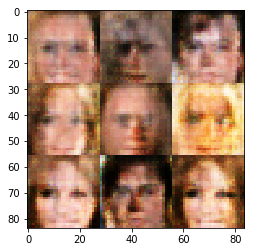

Epoch    1/1	D Loss: 0.5531	G Loss: 1.8611
Epoch    1/1	D Loss: 0.6698	G Loss: 1.4206
Epoch    1/1	D Loss: 1.1428	G Loss: 3.1755
Epoch    1/1	D Loss: 0.6712	G Loss: 1.8651
Epoch    1/1	D Loss: 0.6300	G Loss: 2.2678
Epoch    1/1	D Loss: 0.6120	G Loss: 1.9387
Epoch    1/1	D Loss: 0.7987	G Loss: 1.1062
Epoch    1/1	D Loss: 0.7896	G Loss: 1.5758
Epoch    1/1	D Loss: 0.6644	G Loss: 1.1763
Epoch    1/1	D Loss: 0.6191	G Loss: 1.3129


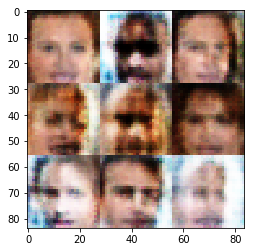

Epoch    1/1	D Loss: 0.9081	G Loss: 0.9135
Epoch    1/1	D Loss: 0.5575	G Loss: 2.1216
Epoch    1/1	D Loss: 0.7789	G Loss: 2.0856
Epoch    1/1	D Loss: 0.6050	G Loss: 1.2480
Epoch    1/1	D Loss: 1.3091	G Loss: 3.2580
Epoch    1/1	D Loss: 0.7065	G Loss: 2.0367
Epoch    1/1	D Loss: 0.6206	G Loss: 1.4958
Epoch    1/1	D Loss: 0.5214	G Loss: 1.5352
Epoch    1/1	D Loss: 0.6784	G Loss: 1.0956
Epoch    1/1	D Loss: 0.6115	G Loss: 1.3620


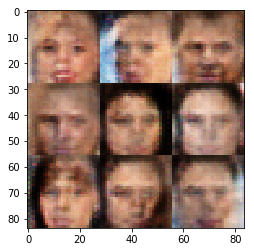

Epoch    1/1	D Loss: 0.7874	G Loss: 2.7502
Epoch    1/1	D Loss: 0.7878	G Loss: 1.1846
Epoch    1/1	D Loss: 0.6886	G Loss: 1.4245
Epoch    1/1	D Loss: 0.7453	G Loss: 1.1703
Epoch    1/1	D Loss: 0.8975	G Loss: 1.0538
Epoch    1/1	D Loss: 1.1481	G Loss: 0.5916
Epoch    1/1	D Loss: 1.0128	G Loss: 2.2776
Epoch    1/1	D Loss: 0.7022	G Loss: 1.3328
Epoch    1/1	D Loss: 0.7315	G Loss: 2.0228
Epoch    1/1	D Loss: 0.7180	G Loss: 1.0596


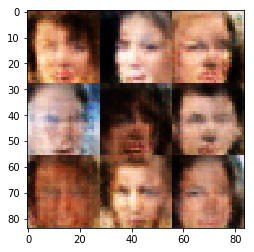

Epoch    1/1	D Loss: 0.8221	G Loss: 0.8820
Epoch    1/1	D Loss: 0.7033	G Loss: 0.9840
Epoch    1/1	D Loss: 0.5006	G Loss: 1.5084
Epoch    1/1	D Loss: 0.5169	G Loss: 1.8431
Epoch    1/1	D Loss: 0.8332	G Loss: 0.9351
Epoch    1/1	D Loss: 0.5402	G Loss: 1.5362
Epoch    1/1	D Loss: 0.6375	G Loss: 2.8372
Epoch    1/1	D Loss: 0.8654	G Loss: 1.9358
Epoch    1/1	D Loss: 1.0561	G Loss: 0.5946


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 10)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.